## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test
import energyefficiencyDataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
import numpy as np 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 
import statsModel
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import pytorch_tabnet

## Parameters
ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
#ABC Generator Parameters
abc_mean = 1
variance = 1
bias = 1 
#Training parameters 
n_epochs = 1000

In [4]:
# Parameters
variance = 0.01
bias = 0.01


## Dataset

In [5]:
#Parameters 
n_features = 8
n_samples= 768
n_target = 1 

In [6]:
X,Y = energyefficiencyDataset.energy_data()
# Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


## Training Parameters 



In [7]:
batch_size = 32
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold and Mean Coeff Values 

Fetch coefficient values from stats model to be used in the ABC pre-generator 

Fetch MSE threshold for training the ABC-GAN 

The ABC-GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 

The threshold mse is the mean mse of Catboost over 10 runs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              996.4
Date:                Sun, 24 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:41:32   Log-Likelihood:                         -96.254
No. Observations:                 614   AIC:                                      206.5
Df Residuals:                     607   BIC:                                      237.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

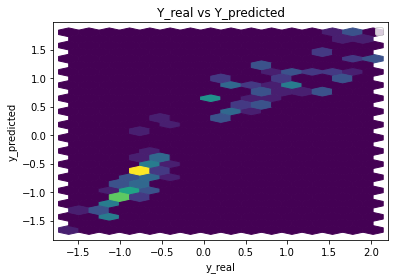

Performance Metrics
Mean Squared Error: 0.09865329524590569
Mean Absolute Error: 0.23061704014626025
Manhattan distance: 35.51502418252408
Euclidean distance: 3.897769550379996


Prior Model MSE 0.23061704014626025


ABC Pre-generator MAE 0.2314213091297399


In [8]:
coeff , y_pred =statsModel.statsModel(X_train,Y_train,X_test,Y_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mae)
print("Prior Model MSE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MAE",mae)
print("ABC Pre-generator MAE",mae)

# mGAN 

In [9]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
#Training the ABC_GAN 
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_1 Generator Loss",genLossA1)
sb.glue("ABC_GAN_1 Discriminator Loss",discLossA1)

In [11]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,test_data,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)
print('MAE:', mean(ABC_GAN1_metrics[1]))

MAE: 0.2783728176752081


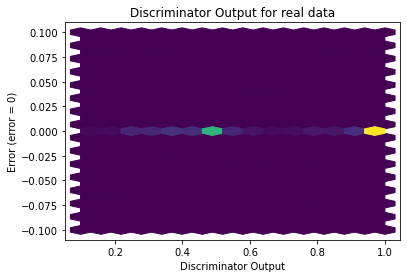

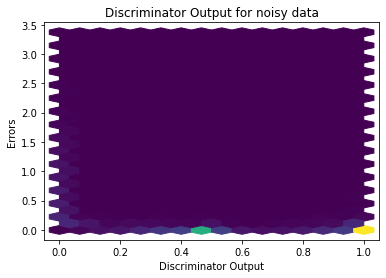

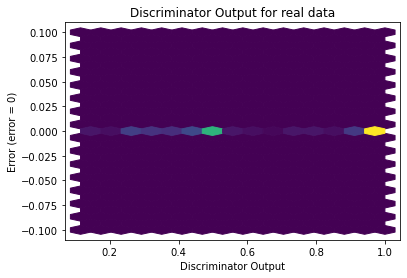

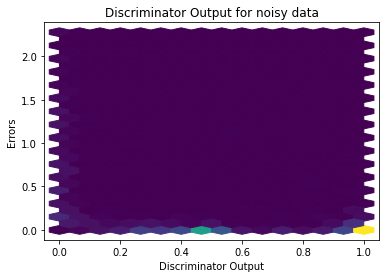

In [12]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# mGAN Tabnet Generator

In [13]:
gen2 = network.GeneratorTabnet(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [14]:
#Training the ABC_GAN 
discLossA2,genLossA2 = ABC_train_test.training_GAN(disc2, gen2,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_2 Generator Loss",genLossA2)
sb.glue("ABC_GAN_2 Discriminator Loss",discLossA2)

In [15]:
ABC_GAN2_metrics=ABC_train_test.test_generator(gen2,test_data,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)
print('MAE:', mean(ABC_GAN2_metrics[1]))

MAE: 0.17276153434096994


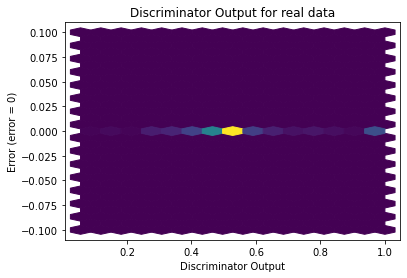

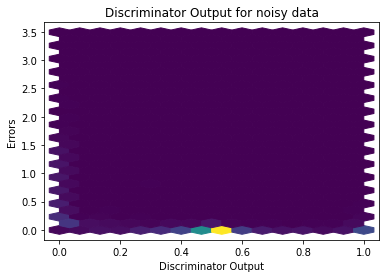

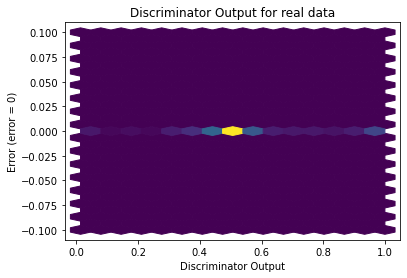

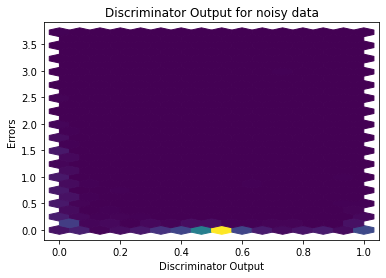

In [16]:
sanityChecks.discProbVsError(train_data,disc2,device)
sanityChecks.discProbVsError(test_data,disc2,device)

# skip-GAN

In [17]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))


In [18]:
discLossA3,genLossA3 = ABC_train_test.training_GAN_skip_connection(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_3 Generator Loss",genLossA3)
sb.glue("ABC_GAN_3 Discriminator Loss",discLossA3)

In [ ]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)
print("MAE:", mean(ABC_GAN3_metrics[1]))

In [ ]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

# skip-GAN TabNet generator

In [ ]:
#Generator
gen4 = network.GeneratorTabnetskipConnection(n_features+1).to(device)
#Discriminator 
disc4 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen4.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc4.parameters(), lr=0.01, betas=(0.5, 0.999))


In [ ]:
discLossA4,genLossA4 = ABC_train_test.training_GAN_skip_connection(disc4, gen4,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_4 Generator Loss",genLossA4)
sb.glue("ABC_GAN_4 Discriminator Loss",discLossA4)

In [ ]:
ABC_GAN4_metrics=ABC_train_test.test_generator(gen4,test_data,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_4 Metrics",ABC_GAN4_metrics)
print("MAE:", mean(ABC_GAN4_metrics[1]))

In [ ]:
sanityChecks.discProbVsError(train_data,disc4,device)
sanityChecks.discProbVsError(test_data,disc4,device)

## Skip Connection Model Analysis - skipGAN

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [ ]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())
        print("Skip Connection Weight",param.item())

In [ ]:
performanceMetrics.modelAnalysis2(ABC_GAN3_metrics)

## Skip Connection Model Analysis - skipGAN (TabNet Generator)

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [ ]:
print("Weight of the node at skip connection")
for name,param in gen4.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())
        print("Skip Connection Weight",param.item())

In [ ]:
performanceMetrics.modelAnalysis2(ABC_GAN4_metrics)